**Word Embedding ของ keras**

In [ ]:
pip install pythainlp



> Import Package ที่จำเป็น การทำ word embedding ของ keras



In [ ]:
import pandas as pd
import re
# from nltk.tokenize import word_tokenize
from pythainlp.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer

from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, LSTM, Bidirectional, Embedding, Dropout, BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.optimizers import Adam

import seaborn as sn
import matplotlib.pyplot as plt

import pickle as p
import plotly
import plotly.graph_objs as go

from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report



> กำหนดจำนวน EPOCHS และ Batch Size


In [ ]:
EPOCHS = 15
BS = 32



> เตรียมข้อมูลในการทำ Sentiment Analysis



In [ ]:
df = pd.read_csv ('Comments.csv',encoding = "utf-8")

In [ ]:
df

,labels,comments
0,pos,ฟังคุณทิมพูด แล้วได้ความรู้เพิ่ม 👏👏
1,pos,ไม่เคยฟังนักการเมืองได้นานขนาดนี้มาก่อนเลย ชื่...
2,pos,ฟังคุณหญิงกับคุณพิธา แล้วรู้สึกมีความหวัง เข้า...
3,pos,เยี่ยม​มาก​ครับ​คุณ​จอมขวัญ ขอบคุณ​สื่อที่กล้า...
4,pos,ขอบคุณคุณพิธาและคุณสุดารัตน์ นี่คือนักวางแผนแล...
...,...,...
495,neg,แหม่​ เอาจำนวนตายจำนวนติดไปเทียบกับประเทศ​ที่ป...
496,neg,รัฐบาลอีโก้สูง มันไม่ฟังอะไรเลยค่ะ
497,neg,มึงตอบได้โคตรผักชีโรยหน้าเลยว่ะ จะเปรียบเทียบก...
498,neg,ไปขุดรมต.มาจากที่ไหน อนาถ


In [ ]:
df = df.drop_duplicates()

In [ ]:
pos_df = df[df.labels == "pos"].sample(250)
pos_df.head()

,labels,comments
245,pos,คุณจอมขวัญถามได้ดีมาก
184,pos,รักคุณทิมและน้องพิพิมค่ะ🥰🥰🥰
134,pos,สส พิธา ทั้งสมอง มีทั้งภาวะผู้นำจริงๆ มันสำคัญ...
95,pos,น้องพิพิมน่าร้ากก​55​ ชอบคนรุ่นใหม่แนวคิดคุณทิ...
76,pos,ฟังคุณทิมแล้วเห็นความหวังมาก


In [ ]:
neg_df = df[df.labels == "neg"].sample(250)
neg_df.head()

,labels,comments
393,neg,เปรียบเทียบกับสงครามก็ยังไม่เห็นภาพอีกแหละครับ...
274,neg,ฟังคำตอบของรมต.ดิจิตอลแล้ว เข้าใจเลยว่าปททมาถึ...
407,neg,ถึงจะชอบขนาดไหน มาเชียร์ซิโนแวค กูก็อัลฟอลค่ะ ...
474,neg,เป็น รมต. ที่ตอบคำถามได้.....อยากส่งยาแดงให้เอ...
267,neg,หน้า กวน...มาก


In [ ]:
sentiment_df = pd.concat([neg_df, pos_df])
sentiment_df.head()

,labels,comments
393,neg,เปรียบเทียบกับสงครามก็ยังไม่เห็นภาพอีกแหละครับ...
274,neg,ฟังคำตอบของรมต.ดิจิตอลแล้ว เข้าใจเลยว่าปททมาถึ...
407,neg,ถึงจะชอบขนาดไหน มาเชียร์ซิโนแวค กูก็อัลฟอลค่ะ ...
474,neg,เป็น รมต. ที่ตอบคำถามได้.....อยากส่งยาแดงให้เอ...
267,neg,หน้า กวน...มาก


In [ ]:
comments = sentiment_df.comments.values
comments.shape

(500,)

In [ ]:
comments[0]

'เปรียบเทียบกับสงครามก็ยังไม่เห็นภาพอีกแหละครับ เพราะว่าไม่เคยรบ สรุปคือไม่เคยบริหารด้านอะไรเลย'

In [ ]:
labels = sentiment_df.labels.values
labels.shape

(500,)



> สร้างFunctionต่างๆ เพื่อสร้างTrain Data



In [ ]:
def cleaning(sentences):
  words = []
  temp = []
  for s in sentences:
    clean = re.sub(r'[^ก-๙]', "", s)
    w = word_tokenize(clean)
    temp.append([i.lower() for i in w])
    words.append(' '.join(w).lower())
    
  return words, temp

In [ ]:
cleaned_words, temp = cleaning(comments)
print(len(cleaned_words))
print(cleaned_words[:5])

500
['เปรียบเทียบ กับ สงคราม ก็ ยัง ไม่ เห็นภาพ อีก แหละ ครับ เพราะว่า ไม่ เคย รบ สรุป คือ ไม่ เคย บริหาร ด้าน อะไร เลย', 'ฟัง คำตอบ ของ รม ต ดิจิตอล แล้ว เข้าใจ เลย ว่า ปทท มาถึง จุด นี้ ได้ ไง ล้มเหลว ได้ขนาด นี้ เพราะ พวก ท่าน ๆ นี้ เอง ไม่ รู้ตัว แถ ได้ ตลอด เวรกรรม ของ ปชช ที่ ได้ คน บริหาร ปท แบบนี้', 'ถึง จะ ชอบ ขนาด ไหน มา เชียร์ ซิ โน แวค กู ก็ อัลฟอล ค่ะ ขนาด มึง ใช้ ดารา ดัง ๆ ที่ กู ชอบ กู ก็ บาย ค่ะ', 'เป็น รม ต ที่ ตอบคำถาม ได้ อยาก ส่ง ยาแดง ให้ เอา ทา สีข้าง เลย', 'หน้า กวน มาก']


In [ ]:
def create_tokenizer(words, filters = ''):
    token = Tokenizer(filters=filters)
    token.fit_on_texts(words)
    return token

In [ ]:
train_word_tokenizer = create_tokenizer(cleaned_words)
vocab_size = len(train_word_tokenizer.word_index) + 1

train_word_tokenizer.word_index

{'ไม่': 1,
 'คุณ': 2,
 'ที่': 3,
 'มาก': 4,
 'ได้': 5,
 'ครับ': 6,
 'มี': 7,
 'เลย': 8,
 'แล้ว': 9,
 'มา': 10,
 'จอมขวัญ': 11,
 'เป็น': 12,
 'ไป': 13,
 'คน': 14,
 'ค่ะ': 15,
 'ทิม': 16,
 'ให้': 17,
 'แต่': 18,
 'พูด': 19,
 'และ': 20,
 'ฟัง': 21,
 'ว่า': 22,
 'ก็': 23,
 'ๆ': 24,
 'นี้': 25,
 'รัฐบาล': 26,
 'ประชาชน': 27,
 'จะ': 28,
 'มัน': 29,
 'กับ': 30,
 'ของ': 31,
 'ประเทศ': 32,
 'พิธา': 33,
 'รัฐมนตรี': 34,
 'ท่าน': 35,
 'คือ': 36,
 'รม': 37,
 'จริงๆ': 38,
 'ต': 39,
 'ใน': 40,
 'แถ': 41,
 'นะ': 42,
 'เรา': 43,
 'เก่ง': 44,
 'ดี': 45,
 'เขา': 46,
 'ชอบ': 47,
 'รู้': 48,
 'เรื่อง': 49,
 'คุณหญิง': 50,
 'อะไร': 51,
 'ดู': 52,
 'กัน': 53,
 'แบบ': 54,
 'แบบนี้': 55,
 'ทำ': 56,
 'โง่': 57,
 'นี่': 58,
 'ต้อง': 59,
 'นะคะ': 60,
 'การ': 61,
 'นายก': 62,
 'ทั้ง': 63,
 'ตอบ': 64,
 'ฉลาด': 65,
 'เหมือน': 66,
 'ข้อมูล': 67,
 'ยัง': 68,
 'เอา': 69,
 'จริง': 70,
 'ไทย': 71,
 'น่ารัก': 72,
 'เพราะ': 73,
 'อย่าง': 74,
 'ขอบคุณ': 75,
 'อยาก': 76,
 'คิด': 77,
 'เห็น': 78,
 'รัฐ': 79,
 'สุดยอด': 80,
 

In [ ]:
def max_length(words):
    return(len(max(words, key = len)))

In [ ]:
max_length = max_length(temp)
max_length

65

In [ ]:
def encoding_doc(token, words):
    return(token.texts_to_sequences(words))

In [ ]:
encoded_doc = encoding_doc(train_word_tokenizer, cleaned_words)

print(cleaned_words[0])
print(encoded_doc[0])

เปรียบเทียบ กับ สงคราม ก็ ยัง ไม่ เห็นภาพ อีก แหละ ครับ เพราะว่า ไม่ เคย รบ สรุป คือ ไม่ เคย บริหาร ด้าน อะไร เลย
[223, 30, 726, 23, 68, 1, 340, 84, 454, 6, 727, 1, 96, 341, 455, 36, 1, 96, 92, 456, 51, 8]


In [ ]:
def padding_doc(encoded_doc, max_length):
    return(pad_sequences(encoded_doc, maxlen = max_length, padding = "post"))

In [ ]:
padded_doc = padding_doc(encoded_doc, max_length)
print("Shape of padded docs = ",padded_doc.shape)

print(cleaned_words[0])
print(encoded_doc[0])
print(padded_doc[0])

Shape of padded docs =  (500, 65)
เปรียบเทียบ กับ สงคราม ก็ ยัง ไม่ เห็นภาพ อีก แหละ ครับ เพราะว่า ไม่ เคย รบ สรุป คือ ไม่ เคย บริหาร ด้าน อะไร เลย
[223, 30, 726, 23, 68, 1, 340, 84, 454, 6, 727, 1, 96, 341, 455, 36, 1, 96, 92, 456, 51, 8]
[223  30 726  23  68   1 340  84 454   6 727   1  96 341 455  36   1  96
  92 456  51   8   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0]


In [ ]:
unique_labels = list(set(labels))
unique_labels

['pos', 'neg']

In [ ]:
output_tokenizer = create_tokenizer(unique_labels)

In [ ]:
encoded_output = encoding_doc(output_tokenizer, labels)
print(labels[0:2])
print(encoded_output[0:2])

['neg' 'neg']
[[2], [2]]


In [ ]:
encoded_output = np.array(encoded_output).reshape(len(encoded_output), 1)
encoded_output.shape

(500, 1)

In [ ]:
def one_hot(encode):
  oh = OneHotEncoder(sparse = False)
  return(oh.fit_transform(encode))

In [ ]:
output_one_hot = one_hot(encoded_output)
print(encoded_output[0])
print(output_one_hot[0])

[2]
[0. 1.]




> แบ่งDataset สำหรับ Train 80% และ Validate 20%



In [ ]:
train_X, val_X, train_Y, val_Y = train_test_split(padded_doc, output_one_hot, shuffle = True, test_size = 0.2, stratify=output_one_hot)

In [ ]:
print("Shape of train_X = %s and train_Y = %s" % (train_X.shape, train_Y.shape))
print("Shape of val_X = %s and val_Y = %s" % (val_X.shape, val_Y.shape))

Shape of train_X = (400, 65) and train_Y = (400, 2)
Shape of val_X = (100, 65) and val_Y = (100, 2)


In [ ]:
num_classes = len(unique_labels)



> นิยาม Model แบบ GRU

*   กำหนด learning_rate=0.001
*   กำหนด dropout = 0.7





In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, LSTM, Bidirectional, Embedding, Dropout, BatchNormalization
from tensorflow.keras.models import load_model

from tensorflow.keras.optimizers import Adam
adam = Adam(learning_rate=0.001)

def create_model(vocab_size, max_length):
  model = Sequential()
  
  model.add(Embedding(vocab_size, 128, input_length = max_length,  trainable = True))
  model.add(Bidirectional(GRU(128, activation = "relu"))) # activation = "relu"
  model.add(Dense(128, activation = "relu"))
  model.add(Dropout(0.7))
  model.add(Dense(64, activation = "relu"))
  model.add(Dropout(0.7))
  model.add(BatchNormalization())
  model.add(Dense(num_classes, activation = "softmax"))
  
  return model
  
model = create_model(vocab_size, max_length)

In [ ]:
model.compile(loss = "categorical_crossentropy", optimizer = adam, metrics = ["accuracy"])
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 65, 128)           202496    
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 256)               198144    
_________________________________________________________________
dense_30 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_21 (Dropout)         (None, 64)                0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 64)              



> สร้างจุด Check Point เพื่อ Save Model



In [ ]:
filename = 'model.h5_kr'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')



> Train Model



In [ ]:
hist = model.fit(train_X, train_Y, epochs = EPOCHS, batch_size = BS, validation_data = (val_X, val_Y), callbacks = [checkpoint])

Epoch 1/15
13/13 [==============================] - 8s 418ms/step - loss: 0.7762 - accuracy: 0.5250 - val_loss: 0.6900 - val_accuracy: 0.7200

Epoch 00001: val_loss improved from inf to 0.69004, saving model to model.h5_kr
INFO:tensorflow:Assets written to: model.h5_kr/assets
Epoch 2/15
13/13 [==============================] - 3s 268ms/step - loss: 0.7736 - accuracy: 0.5175 - val_loss: 0.6880 - val_accuracy: 0.7800

Epoch 00002: val_loss improved from 0.69004 to 0.68795, saving model to model.h5_kr
INFO:tensorflow:Assets written to: model.h5_kr/assets
Epoch 3/15
13/13 [==============================] - 4s 293ms/step - loss: 0.6604 - accuracy: 0.6100 - val_loss: 0.6820 - val_accuracy: 0.7800

Epoch 00003: val_loss improved from 0.68795 to 0.68196, saving model to model.h5_kr
INFO:tensorflow:Assets written to: model.h5_kr/assets
Epoch 4/15
13/13 [==============================] - 4s 281ms/step - loss: 0.5836 - accuracy: 0.6800 - val_loss: 0.6662 - val_accuracy: 0.8700

Epoch 00004: val_l



> Save History



In [ ]:
with open('history_model_kr', 'wb') as file:
    p.dump(hist.history, file)



> Load History



In [ ]:
with open('history_model_kr', 'rb') as file:
    his = p.load(file)



> Plot Loss และ Validate Loss





In [ ]:
from IPython.display import HTML

In [ ]:
plotly.offline.init_notebook_mode(connected=True)

h1 = go.Scatter(y=his['loss'], 
                    mode="lines", line=dict(
                    width=2,
                    color='blue'),
                    name="loss"
                   )
h2 = go.Scatter(y=his['val_loss'], 
                    mode="lines", line=dict(
                    width=2,
                    color='red'),
                    name="val_loss"
                   )

data = [h1,h2]
layout1 = go.Layout(title='Loss',
                   xaxis=dict(title='epochs'),
                   yaxis=dict(title=''))
fig1 = go.Figure(data = data, layout=layout1)
plotly.offline.iplot(fig1, filename="Intent Classification")
HTML(fig1.to_html())

Output hidden; open in https://colab.research.google.com to view.



> Plot Accuracy และ Validate Accuracy



In [ ]:
h1 = go.Scatter(y=his['accuracy'], 
                    mode="lines", line=dict(
                    width=2,
                    color='blue'),
                    name="acc"
                   )
h2 = go.Scatter(y=his['val_accuracy'], 
                    mode="lines", line=dict(
                    width=2,
                    color='red'),
                    name="val_acc"
                   )

data = [h1,h2]
layout1 = go.Layout(title='Accuracy',
                   xaxis=dict(title='epochs'),
                   yaxis=dict(title=''))
fig1 = go.Figure(data = data, layout=layout1)
plotly.offline.iplot(fig1, filename="Intent Classification")
HTML(fig1.to_html())

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
predict_model = load_model(filename) 
predict_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 65, 128)           202496    
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 256)               198144    
_________________________________________________________________
dense_30 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_21 (Dropout)         (None, 64)                0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 64)              

In [ ]:
score = predict_model.evaluate(val_X, val_Y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.23968687653541565
Test accuracy: 0.9100000262260437


In [ ]:
predicted_classes = predict_model.predict_classes(val_X)
predicted_classes.shape

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



(100,)

In [ ]:
y_true = np.argmax(val_Y,axis = 1)
print(val_Y[0])
print(y_true[0])

[0. 1.]
1




> Save Confusion Matrix



In [ ]:
cm = confusion_matrix(y_true, predicted_classes)
np.savetxt("confusion_matrix_kr.csv", cm, delimiter=",")



> Plot Confusion Matrix



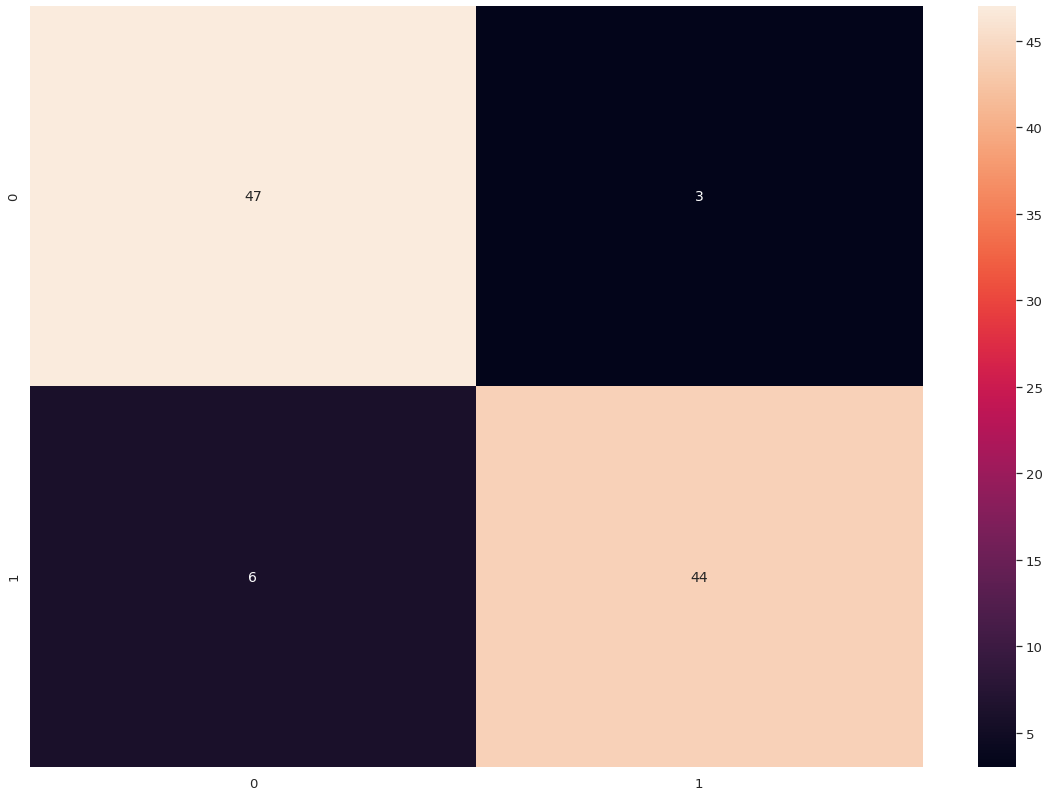

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, range(2), range(2))
plt.figure(figsize=(20,14))
sn.set(font_scale=1.2) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 14}, fmt='g') # for num predict size

plt.show()

In [ ]:
label_dict = output_tokenizer.word_index

In [ ]:
label = [key for key, value in label_dict.items()]



> แสดง Precision, Recall, F1-score



In [ ]:
print(classification_report(y_true, predicted_classes, target_names=label, digits=4))

              precision    recall  f1-score   support

         pos     0.8868    0.9400    0.9126        50
         neg     0.9362    0.8800    0.9072        50

    accuracy                         0.9100       100
   macro avg     0.9115    0.9100    0.9099       100
weighted avg     0.9115    0.9100    0.9099       100



**Word2Vec Transfer Learning ด้วย gensim**




In [ ]:
pip install --upgrade gensim

> Import Package ที่จำเป็น การทำ W2V Tranfer Learning ด้วย gensim

In [ ]:
from gensim.models import Word2Vec

In [ ]:
dimension = 128

In [ ]:
sentences = [st.split() for st in cleaned_words]

In [ ]:
w2v_model = Word2Vec(sentences, min_count=1, vector_size=dimension, workers=6, sg=1, epochs=1000)

In [ ]:
w2v_model.save('w2v_model_gs.bin')

In [ ]:
new_model = Word2Vec.load('w2v_model_gs.bin')

> นิยาม Model แบบ Gensim

*   กำหนด learning_rate=0.001
*   กำหนด dropout = 0.7


In [ ]:
embedding_matrix = np.zeros((vocab_size, dimension))

for word, i in train_word_tokenizer.word_index.items():
    if word in new_model.wv.key_to_index:
        embedding_vector = new_model.wv[word]
        embedding_matrix[i] = embedding_vector
adam = Adam(learning_rate=0.001)

def create_model(vocab_size, max_length):
  model = Sequential()
  
  model.add(Embedding(vocab_size, dimension, input_length = max_length, trainable = False, weights=[embedding_matrix]))
  model.add(Bidirectional(GRU(128, activation = "relu")))
  model.add(Dense(128, activation = "relu"))
  model.add(Dropout(0.7))
  model.add(Dense(64, activation = "relu"))
  model.add(Dropout(0.7))
  model.add(BatchNormalization())
  model.add(Dense(num_classes, activation = "softmax"))
  
  return model
  
model = create_model(vocab_size, max_length)

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 65, 128)           202496    
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 256)               198144    
_________________________________________________________________
dense_33 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_22 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_23 (Dropout)         (None, 64)                0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 64)              


> สร้างจุด Check Point เพื่อ Save Model



In [ ]:
filename = 'model.h5_gs'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')



> Train Model



In [ ]:
hist = model.fit(train_X, train_Y, epochs = EPOCHS, batch_size = BS, validation_data = (val_X, val_Y), callbacks = [checkpoint])

Epoch 1/15
13/13 [==============================] - 6s 291ms/step - loss: 0.9686 - accuracy: 0.5225 - val_loss: 0.6640 - val_accuracy: 0.5800

Epoch 00001: val_loss improved from inf to 0.66397, saving model to model.h5_gs
INFO:tensorflow:Assets written to: model.h5_gs/assets
Epoch 2/15
13/13 [==============================] - 3s 249ms/step - loss: 0.8507 - accuracy: 0.5725 - val_loss: 0.6181 - val_accuracy: 0.7900

Epoch 00002: val_loss improved from 0.66397 to 0.61805, saving model to model.h5_gs
INFO:tensorflow:Assets written to: model.h5_gs/assets
Epoch 3/15
13/13 [==============================] - 3s 258ms/step - loss: 0.7207 - accuracy: 0.6275 - val_loss: 0.5774 - val_accuracy: 0.8500

Epoch 00003: val_loss improved from 0.61805 to 0.57739, saving model to model.h5_gs
INFO:tensorflow:Assets written to: model.h5_gs/assets
Epoch 4/15
13/13 [==============================] - 3s 257ms/step - loss: 0.6761 - accuracy: 0.6675 - val_loss: 0.5324 - val_accuracy: 0.9000

Epoch 00004: val_l



> Save History



In [ ]:
with open('history_model_gs', 'wb') as file:
    p.dump(hist.history, file)


> Load History



In [ ]:
with open('history_model_gs', 'rb') as file:
    his = p.load(file)


> Plot Loss และ Validate Loss


In [ ]:
from IPython.display import HTML

In [ ]:
plotly.offline.init_notebook_mode(connected=True)

h1 = go.Scatter(y=his['loss'], 
                    mode="lines", line=dict(
                    width=2,
                    color='blue'),
                    name="loss"
                   )
h2 = go.Scatter(y=his['val_loss'], 
                    mode="lines", line=dict(
                    width=2,
                    color='red'),
                    name="val_loss"
                   )

data = [h1,h2]
layout1 = go.Layout(title='Loss',
                   xaxis=dict(title='epochs'),
                   yaxis=dict(title=''))
fig1 = go.Figure(data = data, layout=layout1)
plotly.offline.iplot(fig1, filename="Intent Classification")
HTML(fig1.to_html())

Output hidden; open in https://colab.research.google.com to view.


> Plot Accuracy และ Validate Accuracy



In [ ]:
h1 = go.Scatter(y=his['accuracy'], 
                    mode="lines", line=dict(
                    width=2,
                    color='blue'),
                    name="acc"
                   )
h2 = go.Scatter(y=his['val_accuracy'], 
                    mode="lines", line=dict(
                    width=2,
                    color='red'),
                    name="val_acc"
                   )

data = [h1,h2]
layout1 = go.Layout(title='Accuracy',
                   xaxis=dict(title='epochs'),
                   yaxis=dict(title=''))
fig1 = go.Figure(data = data, layout=layout1)
plotly.offline.iplot(fig1, filename="Intent Classification")
HTML(fig1.to_html())

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
predict_model = load_model(filename) 
predict_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 65, 128)           202496    
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 256)               198144    
_________________________________________________________________
dense_33 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_22 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_23 (Dropout)         (None, 64)                0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 64)              

In [ ]:
score = predict_model.evaluate(val_X, val_Y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.1484445333480835
Test accuracy: 0.9200000166893005


In [ ]:
predicted_classes = predict_model.predict_classes(val_X)
predicted_classes.shape

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



(100,)

In [ ]:
y_true = np.argmax(val_Y,axis = 1)
print(val_Y[0])
print(y_true[0])

[0. 1.]
1




> Save Confusion Matrix



In [ ]:
cm = confusion_matrix(y_true, predicted_classes)
np.savetxt("confusion_matrix_gs.csv", cm, delimiter=",")


> Plot Confusion Matrix



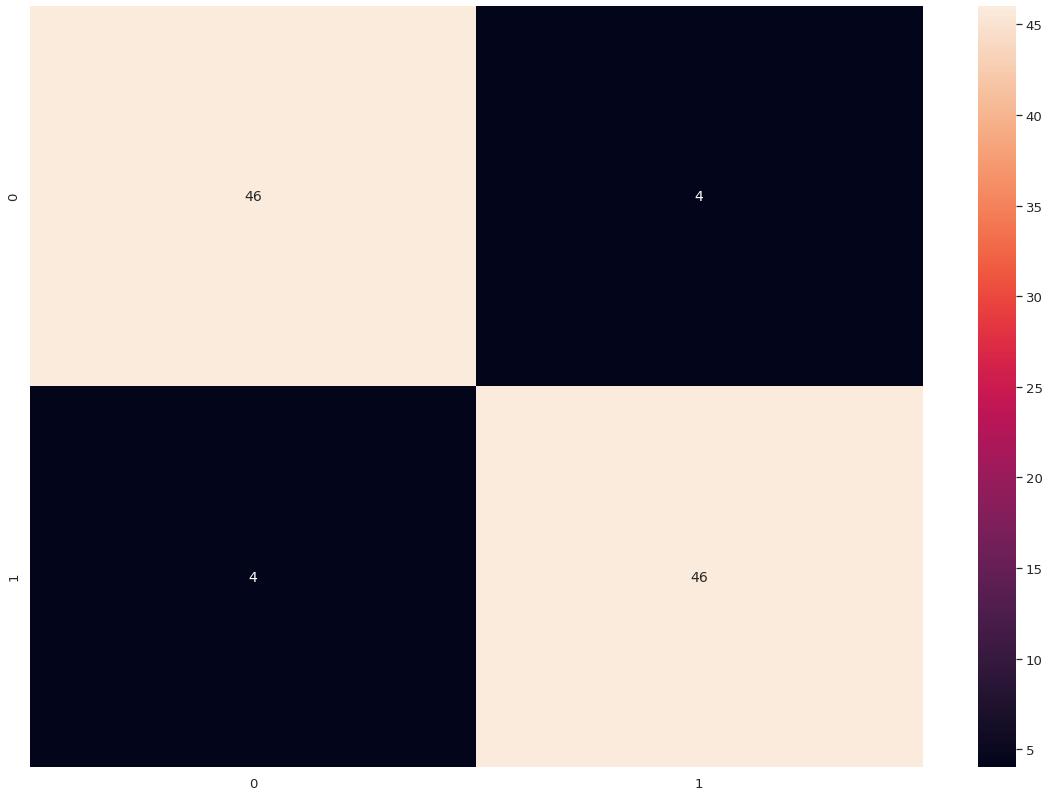

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, range(2), range(2))
plt.figure(figsize=(20,14))
sn.set(font_scale=1.2) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 14}, fmt='g') # for num predict size

plt.show()

In [ ]:
label_dict = output_tokenizer.word_index

In [ ]:
label = [key for key, value in label_dict.items()]



> แสดง Precision, Recall, F1-score



In [ ]:
print(classification_report(y_true, predicted_classes, target_names=label, digits=4))

              precision    recall  f1-score   support

         pos     0.9200    0.9200    0.9200        50
         neg     0.9200    0.9200    0.9200        50

    accuracy                         0.9200       100
   macro avg     0.9200    0.9200    0.9200       100
weighted avg     0.9200    0.9200    0.9200       100

